A cuda device was detected.
NVIDIA GeForce RTX 2060
Total Loss:  106.28543923017514
Total Loss:  35.4319934275741
Total Loss:  26.655693652717616
Total Loss:  20.44502148489221
Total Loss:  15.519869504200415
Total Loss:  11.568496975555433
Total Loss:  8.78447166451447
Total Loss:  6.653919556969242
Total Loss:  5.0891483727856475
Total Loss:  3.993973562456091


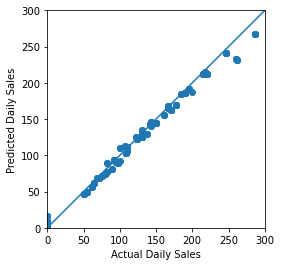

Enter admin username:
admin
Enter admin password:

incorrect password.
Enter admin username:
admin
Enter admin password:
asdf
incorrect password.
Enter admin username:


In [ ]:
dbUsername = 'admin'
dbPassword = 'password'

# Import PyTorch libraries. Pytorch is the main library, and we need the nerual network 'nn' libray from it
import torch
from torch import nn

# Import MatPlogLib library to make cool graphs of the data
import matplotlib.pyplot as plt

# Check to see if we have a GPU to use for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('A {} device was detected.'.format(device))

# Print the name of the cuda device, if detected
if device=='cuda':
    print (torch.cuda.get_device_name(device=device))
    
# Use Pandas to do our dataprocessing on the dataset
# Download the dataset
import pandas as pd
path = 'https://raw.githubusercontent.com/colemasterson/NNProfitData/main/FrisbeeV2.csv'
df = pd.read_csv(path)

# Calculate the mean and standard deviation of price
# Standardize numSold
priceMean = df['Price'].mean()
priceStd = df['Price'].std()
df['Price'] = (df['Price']-priceMean)/priceStd

# Calculate the mean and standard deviation of numSold
# Standardize numSold
numSoldMean = df['NumberSold'].mean()
numSoldStd = df['NumberSold'].std()

df['NumberSold'] = (df['NumberSold']-numSoldMean)/numSoldStd


# Create tensors and move to CPU or GPU if available
# Extract the inputs and create a PyTorch tensor x (inputs)
inputs = ['Weekend','OnHotNow','CompDown','ExtAdvert','Price']

x = torch.tensor(df[inputs].values, dtype=torch.float, device=device)

# Extract the outputs and create a PyTorch tensor y (outputs)
outputs = ['NumberSold']
y = torch.tensor(df[outputs].values,dtype=torch.float, device=device)


# Input Layers: 5
# Hidden Units: 100
# Hidden Layers: 1
# Output Layers: 1

model = nn.Sequential(
            nn.Linear(5,100),
            nn.ReLU(),
            nn.Linear(100,1)           
        )


# Move model to CPU or GPU depending on availability
model.to(device)

import torch.optim as optim

# Meausure performance by mean square error
criterion = torch.nn.MSELoss()

# Train network using SGD algorithm
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

# Train the network on the dataset 10 times
for epoch in range(10):
    totalLoss = 0
    for i in range(len(x)):
        
        # Single Forward Pass
        ypred = model(x[i])
        
        # Measure how accurate the model predicted vs actual
        loss = criterion(ypred, y[i])
        
        # Track how well the model predicted
        totalLoss+=loss.item()
        
        # Update the neural network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print total loss after each epoch
    print ("Total Loss: ", totalLoss)

@torch.no_grad() 

def graphPredictions(model, x, y, minValue, maxValue):
    
    model.eval()                               # Set the model to inference mode
    
    predictions=[]                             # Track predictions
    actual=[]                                  # Track the actual labels
    
    x.to(device)
    y.to(device)
    model.to(device)
    
    for i in range(len(x)):
        
        # Single forward pass
        pred = model(x[i])                               

        # Un-normalize the prediction
        pred = pred*numSoldStd+numSoldMean
        act = y[i]*numSoldStd+numSoldMean
        
        # Save prediction and actual label
        predictions.append(pred.tolist())
        actual.append(act.item())
    
    # Plot actuals vs predictions
    plt.scatter(actual, predictions)
    plt.xlabel('Actual Daily Sales')
    plt.ylabel('Predicted Daily Sales')
    plt.plot([minValue,maxValue], [minValue,maxValue]) 
    plt.xlim(minValue, maxValue)
    plt.ylim(minValue, maxValue)
 
    # Make the display equal in both dimensions
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig("output1.jpg")
    plt.show()

def datasetGenerator(weekend, onhotnow, compdown, extadvert, price):
    numSold = 0
    if weekend:
        numSold = (onhotnow*5  + int(500 / price))
        if onhotnow:
            numSold = 1.3 * numSold
        if compdown:
            numSold = 2 * numSold
        if extadvert:
            numSold = 1.25 * numSold
    numSold = int(numSold)    
    return numSold

def runSingleTest(weekendIn, hotNowIn, compDownIn, extAdvertIn, priceIn):
    # Input data that affects total number of items sold
    weekend = weekendIn
    hotnow = hotNowIn
    compdown = compDownIn  
    extadvert = extAdvertIn
    price = priceIn

    # Calculate actual result using dataset generator
    actual = datasetGenerator(weekend, hotnow, compdown, extadvert, price) 

    # Use CPU for the single pass
    model.to('cpu')

    # Normalize inputs using training values
    price = (price - priceMean)/priceStd

    # Create input tensor
    x1 = torch.tensor([weekend, hotnow, compdown, extadvert, price],dtype=float)

    # Pass input into neural network
    y1 = model(x1.float())

    # Un-normalize output y1
    y1 = y1*numSoldStd+numSoldMean
    
    # Compare what the neural network predicted compared the actual
    print ("Neural Network Predicts: ", round(y1.item(), 4))
    print ("Actual Result: ", actual)
    # Calculate daily revenues
    realPrice = price*priceStd+priceMean
    revDaily = y1.item() * realPrice
    revWeekly = 7 * revDaily
    revAnnual = 365 * revDaily
    
    print ("-------------------------------------")
    print ("Estimated Item Revenue: ")
    print ("24 Hour: $" + str(round(revDaily, 2)))
    print ("Weekly: $" + str(round(revWeekly, 2)))
    print ("Annual: $" + str(round(revAnnual, 2)))
    print ("-------------------------------------")
        
#run a single test of the neural network
graphPredictions(model, x, y, 0, 300)

exitLoop = False
while exitLoop == False:
    print("Enter admin username:")
    ui = input()
    
    if ui != dbUsername:
        print("incorrect username.")
        continue
    
    print("Enter admin password:")
    up = input()
    
    if up != dbPassword:
        print("incorrect password.")
        continue
    
    exitLoop = True
    
exitLoop = False


while exitLoop == False:
    print("Enter desired selling price or E:")
    userInput = input()
    
    if userInput != "E":
        uPrice = int(userInput)
        runSingleTest(1, 0, 1, 0, uPrice)
    else:
        exitLoop = True